In [2]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import time
import sys
import os 
from scipy.sparse import linalg
from pathlib import Path
import itertools
if torch.cuda.is_available():  
    device = "cuda" 
else:  
    device = "cpu" 

torch.set_default_dtype(torch.float64)
pi = torch.tensor(np.pi,dtype=torch.float64)
ZERO = torch.tensor([0.]).to(device)

class model(nn.Module):
    """ ReLU k shallow neural network
    Parameters: 
    input size: input dimension
    hidden_size1 : number of hidden layers 
    num_classes: output classes 
    k: degree of relu functions
    """
    def __init__(self, input_size, hidden_size1, num_classes,k = 1):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, num_classes,bias = False)
        self.k = k 
    def forward(self, x):
        u1 = self.fc2(F.relu(self.fc1(x))**self.k)
        return u1
    def evaluate_derivative(self, x, i):
        if self.k == 1:
            u1 = self.fc2(torch.heaviside(self.fc1(x),ZERO) * self.fc1.weight.t()[i-1:i,:] )
        else:
            u1 = self.fc2(self.k*F.relu(self.fc1(x))**(self.k-1) *self.fc1.weight.t()[i-1:i,:] )  
        return u1
    

def plot_2D(f,bl = [0,0], ur=[1,1]): 
    
    Nx = 1000
    Ny = 1000 
    xs = np.linspace(bl[0], ur[0], Nx)
    ys = np.linspace(bl[1], ur[1], Ny)
    x, y = np.meshgrid(xs, ys, indexing='xy')
    xy_comb = np.stack((x.flatten(),y.flatten())).T
    xy_comb = torch.tensor(xy_comb)
    z = f(xy_comb).reshape(Nx,Ny)
    z = z.detach().numpy()
    plt.figure(dpi=200)
    ax = plt.axes(projection='3d')
    ax.plot_surface(x , y , z )

    plt.show()

def plot_2D_L(f, bl=[-1, -1], ur=[1, 1]): 
    Nx = 1000
    Ny = 1000 
    xs = np.linspace(bl[0], ur[0], Nx)
    ys = np.linspace(bl[1], ur[1], Ny)
    x, y = np.meshgrid(xs, ys, indexing='xy')

    # Define mask for the L-shaped domain
    mask = ((x < 0) & (y >= -1) & (y <= 1)) | ((x >= 0) & (x <= 1) & (y >= 0) & (y <= 1))

    xy_comb = np.stack((x.flatten(), y.flatten()), axis=1)
    xy_tensor = torch.tensor(xy_comb, dtype=torch.float32)

    z = f(xy_tensor).detach().numpy().reshape(Nx, Ny)

    # Mask the values outside the L-shape
    z_masked = np.where(mask, z, np.nan)

    # Plot
    fig = plt.figure(dpi=200)
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(x, y, z_masked, cmap='viridis', linewidth=0, antialiased=False)
    ax.set_title("Plot over L-shaped domain")

    plt.show()

In [3]:
def PiecewiseGQ2D_weights_points_general_square(Nx, order,bl = [-1,-1],ur = [1,1]): 
    """ A slight modification of PiecewiseGQ2D function that only needs the weights and integration points.
    Parameters
    Allows a symmetric square domain (around 0) with lower left corner at bl and upper right corner at ur 
    ----------

    Nx: int 
        number of intervals along the dimension. No Ny, assume Nx = Ny
    order: int 
        order of the Gauss Quadrature

    Returns
    -------
    long_weights: torch.tensor
    integration_points: torch.tensor
    """
#     print("order: ",order )
    x, w = np.polynomial.legendre.leggauss(order)
    gauss_pts = np.array(np.meshgrid(x,x,indexing='ij')).reshape(2,-1).T
    weights =  (w*w[:,None]).ravel()

    gauss_pts =torch.tensor(gauss_pts)
    weights = torch.tensor(weights)

    h = (ur[0]- bl[0])/Nx # 100 intervals 
    long_weights =  torch.tile(weights,(Nx**2,1))
    long_weights = long_weights.reshape(-1,1)
    long_weights = long_weights * h**2 /4 

    integration_points = torch.tile(gauss_pts,(Nx**2,1))
    scale_factor = h/2 
    integration_points = scale_factor * integration_points

    index = np.arange(0,Nx)  
    ordered_pairs = np.array(np.meshgrid(index,index,indexing='ij'))
    ordered_pairs = ordered_pairs.reshape(2,-1).T

    # print(ordered_pairs)
    # print()
    ordered_pairs = torch.tensor(ordered_pairs)
    # print(ordered_pairs.size())
    ordered_pairs = torch.tile(ordered_pairs, (1,order**2)) # number of GQ points
    # print(ordered_pairs)

    ordered_pairs =  ordered_pairs.reshape(-1,2)
    # print(ordered_pairs)
    translation = ordered_pairs*h + (torch.tensor(bl) + h/2) 
    # print(translation)

    integration_points = integration_points + translation 
#     print(integration_points.size())
    # func_values = integrand2_torch(integration_points)
    return long_weights, integration_points


In [4]:
def minimize_linear_layer_explicit_assemble(model,target,weights, integration_points,solver="direct"):
    """
    calls the following functions (dependency): 
    1. GQ_piecewise_2D
    input: the nn model containing parameter 
    1. define the loss function  
    2. take derivative to extract the linear system A
    3. call the cg solver in scipy to solve the linear system 
    output: sol. solution of Ax = b
    """
    start_time = time.time() 
    w = model.fc1.weight.data 
    b = model.fc1.bias.data 
    basis_value_col = F.relu(integration_points @ w.t()+ b)**(model.k) 
    weighted_basis_value_col = basis_value_col * weights 
    jac = weighted_basis_value_col.t() @ basis_value_col 
     
    rhs = weighted_basis_value_col.t() @ (target(integration_points)) 
    print("assembling the matrix time taken: ", time.time()-start_time) 
    start_time = time.time()    
    if solver == "cg": 
        sol, exit_code = linalg.cg(np.array(jac.detach().cpu()),np.array(rhs.detach().cpu()),tol=1e-12)
        sol = torch.tensor(sol).view(1,-1)
    elif solver == "direct": 
#         sol = np.linalg.inv( np.array(jac.detach().cpu()) )@np.array(rhs.detach().cpu())
        sol = (torch.linalg.solve( jac.detach(), rhs.detach())).view(1,-1)
    elif solver == "ls":
        sol = (torch.linalg.lstsq(jac.detach().cpu(),rhs.detach().cpu(),driver='gelsd').solution).view(1,-1)
        # sol = (torch.linalg.lstsq(jac.detach(),rhs.detach()).solution).view(1,-1) # gpu/cpu, driver = 'gels', cannot solve singular
    print("solving Ax = b time taken: ", time.time()-start_time)
    return sol 


In [5]:
def generate_relu_dict2D_QMC_new(s,N0):
    # add this method to your notes... otherwise you will forget it 
    samples = torch.randn(s*N0,3) 
    
    samples = samples/samples.norm(dim=1,keepdim=True)  
    
    Wb = samples 

    return Wb 

def OGAL2FittingReLU2D_QMC_Lshape(my_model,target,s,N0,num_epochs,plot_freq, Nx, order, k =1, linear_solver = "direct",Domain = [[0,0],[1,1]]): 
    """ Orthogonal greedy algorithm using 1D ReLU dictionary over [-pi,pi]
    Parameters
    ----------
    my_model: 
        nn model 
    target: 
        target function
    num_epochs: int 
        number of training epochs 
    integration_intervals: int 
        number of subintervals for piecewise numerical quadrature 

    Returns
    -------
    err: tensor 
        rank 1 torch tensor to record the L2 error history  
    model: 
        trained nn model 
    """
    #Todo Done
    # integratoin points on the L-shaped domain
    gw_expand1, integration_points1 = PiecewiseGQ2D_weights_points_general_square(Nx, order,[0,0],[1,1])
    integration_points2 = integration_points1.clone()
    integration_points2[:,0] -= 1  
    integration_points3 = integration_points2.clone()
    integration_points3[:,1] -= 1 
    integration_points = torch.cat((integration_points1, integration_points2, integration_points3),0)
    gw_expand = torch.cat((gw_expand1, gw_expand1, gw_expand1),0)
    gw_expand = gw_expand.to(device)
    integration_points = integration_points.to(device)


    err = torch.zeros(num_epochs+1)
    if my_model == None: 
        func_values = target(integration_points)
        num_neuron = 0

        list_b = []
        list_w = []
    else: 
        func_values = target(integration_points) - my_model(integration_points).detach()
        bias = my_model.fc1.bias.detach().data
        weights = my_model.fc1.weight.detach().data
        num_neuron = int(bias.size(0))

        list_b = list(bias)
        list_w = list(weights)
    
    # initial error Todo Done
    func_values_sqrd = func_values*func_values
    err[0]= torch.sum(func_values_sqrd*gw_expand)**0.5
    start_time = time.time()
    
    solver = linear_solver
    print("using linear solver: ",solver)
    for i in range(num_epochs): 
        relu_dict_parameters = generate_relu_dict2D_QMC_new(s,N0).to(device) 
        print("epoch: ",i+1, end = '\t')
        if num_neuron == 0: 
            func_values = target(integration_points)
        else: 
            func_values = target(integration_points) - my_model(integration_points).detach()

        weight_func_values = func_values*gw_expand  
        basis_values = (F.relu( torch.matmul(integration_points,relu_dict_parameters[:,0:2].T ) - relu_dict_parameters[:,2])**k).T # uses broadcasting

        output = torch.abs(torch.matmul(basis_values,weight_func_values)) # 
        neuron_index = torch.argmax(output.flatten())
        
        # print(neuron_index)
        list_w.append(relu_dict_parameters[neuron_index,0:2]) # 
        list_b.append(-relu_dict_parameters[neuron_index,2])
        num_neuron += 1
        my_model = model(2,num_neuron,1,k).to(device)
        w_tensor = torch.stack(list_w, 0 ) 
        b_tensor = torch.tensor(list_b)
        my_model.fc1.weight.data[:,:] = w_tensor[:,:]
        my_model.fc1.bias.data[:] = b_tensor[:]

        #Todo 
#         sol = minimize_linear_layer(my_model,target,solver,Nx,order)
        sol = minimize_linear_layer_explicit_assemble(my_model,target,gw_expand, integration_points, solver)

        my_model.fc2.weight.data[0,:] = sol[:]
        if (i+1)%plot_freq == 0: 
            plot_2D(my_model.cpu(),Domain[0],Domain[1])
            my_model = my_model.to(device)

        func_values = target(integration_points) - my_model(integration_points).detach()
        func_values_sqrd = func_values*func_values

        #Todo Done 
        err[i+1]= torch.sum(func_values_sqrd*gw_expand)**0.5
    print("time taken: ",time.time() - start_time)
    return err, my_model


using linear solver:  direct
epoch:  1	assembling the matrix time taken:  0.004879951477050781
solving Ax = b time taken:  3.473642587661743
epoch:  2	assembling the matrix time taken:  0.004383563995361328
solving Ax = b time taken:  0.0002048015594482422
epoch:  3	assembling the matrix time taken:  0.00039887428283691406
solving Ax = b time taken:  0.0001621246337890625
epoch:  4	assembling the matrix time taken:  0.0004086494445800781
solving Ax = b time taken:  0.00015687942504882812
epoch:  5	assembling the matrix time taken:  0.0006499290466308594
solving Ax = b time taken:  0.00015974044799804688
epoch:  6	assembling the matrix time taken:  0.0003979206085205078
solving Ax = b time taken:  0.0001571178436279297
epoch:  7	assembling the matrix time taken:  0.0003962516784667969
solving Ax = b time taken:  0.00015211105346679688
epoch:  8	assembling the matrix time taken:  0.0003960132598876953
solving Ax = b time taken:  0.00015115737915039062
epoch:  9	assembling the matrix time

epoch:  96	assembling the matrix time taken:  0.0005385875701904297
solving Ax = b time taken:  0.0005576610565185547
epoch:  97	assembling the matrix time taken:  0.0004913806915283203
solving Ax = b time taken:  0.0004928112030029297
epoch:  98	assembling the matrix time taken:  0.00048065185546875
solving Ax = b time taken:  0.0005095005035400391
epoch:  99	assembling the matrix time taken:  0.0004794597625732422
solving Ax = b time taken:  0.0005123615264892578
epoch:  100	assembling the matrix time taken:  0.0004792213439941406
solving Ax = b time taken:  0.0005028247833251953
epoch:  101	assembling the matrix time taken:  0.00048041343688964844
solving Ax = b time taken:  0.0005042552947998047
epoch:  102	assembling the matrix time taken:  0.00047898292541503906
solving Ax = b time taken:  0.0005102157592773438
epoch:  103	assembling the matrix time taken:  0.0004892349243164062
solving Ax = b time taken:  0.0005092620849609375
epoch:  104	assembling the matrix time taken:  0.000

epoch:  168	assembling the matrix time taken:  0.0005068778991699219
solving Ax = b time taken:  0.0012359619140625
epoch:  169	assembling the matrix time taken:  0.0005035400390625
solving Ax = b time taken:  0.0011670589447021484
epoch:  170	assembling the matrix time taken:  0.0005152225494384766
solving Ax = b time taken:  0.001149892807006836
epoch:  171	assembling the matrix time taken:  0.0005006790161132812
solving Ax = b time taken:  0.0011756420135498047
epoch:  172	assembling the matrix time taken:  0.0005016326904296875
solving Ax = b time taken:  0.001154184341430664
epoch:  173	assembling the matrix time taken:  0.0005102157592773438
solving Ax = b time taken:  0.0011777877807617188
epoch:  174	assembling the matrix time taken:  0.0005087852478027344
solving Ax = b time taken:  0.0011875629425048828
epoch:  175	assembling the matrix time taken:  0.0004999637603759766
solving Ax = b time taken:  0.0011937618255615234
epoch:  176	assembling the matrix time taken:  0.0005018

epoch:  253	assembling the matrix time taken:  0.0005040168762207031
solving Ax = b time taken:  0.0018796920776367188
epoch:  254	assembling the matrix time taken:  0.0005083084106445312
solving Ax = b time taken:  0.0019011497497558594
epoch:  255	assembling the matrix time taken:  0.0005125999450683594
solving Ax = b time taken:  0.0018978118896484375
epoch:  256	assembling the matrix time taken:  0.0005023479461669922
solving Ax = b time taken:  0.0018901824951171875
epoch:  257	assembling the matrix time taken:  0.0005173683166503906
solving Ax = b time taken:  0.002353668212890625
epoch:  258	assembling the matrix time taken:  0.0005152225494384766
solving Ax = b time taken:  0.0023641586303710938
epoch:  259	assembling the matrix time taken:  0.0005030632019042969
solving Ax = b time taken:  0.0023899078369140625
epoch:  260	assembling the matrix time taken:  0.0005075931549072266
solving Ax = b time taken:  0.0023505687713623047
epoch:  261	assembling the matrix time taken:  0.

solving Ax = b time taken:  0.0031843185424804688
epoch:  323	assembling the matrix time taken:  0.0005128383636474609
solving Ax = b time taken:  0.003205537796020508
epoch:  324	assembling the matrix time taken:  0.0005109310150146484
solving Ax = b time taken:  0.0031633377075195312
epoch:  325	assembling the matrix time taken:  0.0005586147308349609
solving Ax = b time taken:  0.0031592845916748047
epoch:  326	assembling the matrix time taken:  0.0005185604095458984
solving Ax = b time taken:  0.0031926631927490234
epoch:  327	assembling the matrix time taken:  0.0005133152008056641
solving Ax = b time taken:  0.003214597702026367
epoch:  328	assembling the matrix time taken:  0.0005121231079101562
solving Ax = b time taken:  0.0031881332397460938
epoch:  329	assembling the matrix time taken:  0.0005795955657958984
solving Ax = b time taken:  0.0031690597534179688
epoch:  330	assembling the matrix time taken:  0.0005247592926025391
solving Ax = b time taken:  0.0032320022583007812


epoch:  396	assembling the matrix time taken:  0.00057220458984375
solving Ax = b time taken:  0.004080533981323242
epoch:  397	assembling the matrix time taken:  0.0005147457122802734
solving Ax = b time taken:  0.004237651824951172
epoch:  398	assembling the matrix time taken:  0.000560760498046875
solving Ax = b time taken:  0.00418853759765625
epoch:  399	assembling the matrix time taken:  0.0005249977111816406
solving Ax = b time taken:  0.004220008850097656
epoch:  400	assembling the matrix time taken:  0.0005655288696289062
solving Ax = b time taken:  0.0041370391845703125
epoch:  401	assembling the matrix time taken:  0.0005235671997070312
solving Ax = b time taken:  0.004264354705810547
epoch:  402	assembling the matrix time taken:  0.0005602836608886719
solving Ax = b time taken:  0.004216432571411133
epoch:  403	assembling the matrix time taken:  0.0005044937133789062
solving Ax = b time taken:  0.0042879581451416016
epoch:  404	assembling the matrix time taken:  0.000557422

solving Ax = b time taken:  0.0049591064453125
epoch:  473	assembling the matrix time taken:  0.0005035400390625
solving Ax = b time taken:  0.005020856857299805
epoch:  474	assembling the matrix time taken:  0.0005104541778564453
solving Ax = b time taken:  0.004997730255126953
epoch:  475	assembling the matrix time taken:  0.0005109310150146484
solving Ax = b time taken:  0.005020856857299805
epoch:  476	assembling the matrix time taken:  0.0005137920379638672
solving Ax = b time taken:  0.004979372024536133
epoch:  477	assembling the matrix time taken:  0.0005142688751220703
solving Ax = b time taken:  0.005022287368774414
epoch:  478	assembling the matrix time taken:  0.0005128383636474609
solving Ax = b time taken:  0.005019664764404297
epoch:  479	assembling the matrix time taken:  0.0005199909210205078
solving Ax = b time taken:  0.004992246627807617
epoch:  480	assembling the matrix time taken:  0.0005156993865966797
solving Ax = b time taken:  0.0049800872802734375
epoch:  481

epoch:  552	assembling the matrix time taken:  0.0005426406860351562
solving Ax = b time taken:  0.0063707828521728516
epoch:  553	assembling the matrix time taken:  0.000537872314453125
solving Ax = b time taken:  0.006455659866333008
epoch:  554	assembling the matrix time taken:  0.0005021095275878906
solving Ax = b time taken:  0.00647425651550293
epoch:  555	assembling the matrix time taken:  0.0004885196685791016
solving Ax = b time taken:  0.006524801254272461
epoch:  556	assembling the matrix time taken:  0.0004968643188476562
solving Ax = b time taken:  0.006451129913330078
epoch:  557	assembling the matrix time taken:  0.0004887580871582031
solving Ax = b time taken:  0.00652766227722168
epoch:  558	assembling the matrix time taken:  0.00048661231994628906
solving Ax = b time taken:  0.0065135955810546875
epoch:  559	assembling the matrix time taken:  0.0005300045013427734
solving Ax = b time taken:  0.006475925445556641
epoch:  560	assembling the matrix time taken:  0.0004889

solving Ax = b time taken:  0.007794380187988281
epoch:  631	assembling the matrix time taken:  0.0005123615264892578
solving Ax = b time taken:  0.007781982421875
epoch:  632	assembling the matrix time taken:  0.0004978179931640625
solving Ax = b time taken:  0.0077550411224365234
epoch:  633	assembling the matrix time taken:  0.0005667209625244141
solving Ax = b time taken:  0.007767915725708008
epoch:  634	assembling the matrix time taken:  0.0005009174346923828
solving Ax = b time taken:  0.007813453674316406
epoch:  635	assembling the matrix time taken:  0.0005800724029541016
solving Ax = b time taken:  0.007776498794555664
epoch:  636	assembling the matrix time taken:  0.00048732757568359375
solving Ax = b time taken:  0.00779414176940918
epoch:  637	assembling the matrix time taken:  0.0004875659942626953
solving Ax = b time taken:  0.007871389389038086
epoch:  638	assembling the matrix time taken:  0.0004885196685791016
solving Ax = b time taken:  0.007838964462280273
epoch:  6

epoch:  700	assembling the matrix time taken:  0.0004961490631103516
solving Ax = b time taken:  0.009266853332519531
epoch:  701	assembling the matrix time taken:  0.0004849433898925781
solving Ax = b time taken:  0.009358882904052734
epoch:  702	assembling the matrix time taken:  0.00048613548278808594
solving Ax = b time taken:  0.009369850158691406
epoch:  703	assembling the matrix time taken:  0.0004971027374267578
solving Ax = b time taken:  0.009370565414428711
epoch:  704	assembling the matrix time taken:  0.0004892349243164062
solving Ax = b time taken:  0.009289741516113281
epoch:  705	assembling the matrix time taken:  0.0004909038543701172
solving Ax = b time taken:  0.00996088981628418
epoch:  706	assembling the matrix time taken:  0.0005407333374023438
solving Ax = b time taken:  0.009874105453491211
epoch:  707	assembling the matrix time taken:  0.0005395412445068359
solving Ax = b time taken:  0.009914398193359375
epoch:  708	assembling the matrix time taken:  0.0004949

solving Ax = b time taken:  0.011742830276489258
epoch:  772	assembling the matrix time taken:  0.0004928112030029297
solving Ax = b time taken:  0.01167154312133789
epoch:  773	assembling the matrix time taken:  0.0004904270172119141
solving Ax = b time taken:  0.011800765991210938
epoch:  774	assembling the matrix time taken:  0.0004961490631103516
solving Ax = b time taken:  0.011560678482055664
epoch:  775	assembling the matrix time taken:  0.0004944801330566406
solving Ax = b time taken:  0.011610746383666992
epoch:  776	assembling the matrix time taken:  0.0004928112030029297
solving Ax = b time taken:  0.011528253555297852
epoch:  777	assembling the matrix time taken:  0.0004954338073730469
solving Ax = b time taken:  0.011658668518066406
epoch:  778	assembling the matrix time taken:  0.0005066394805908203
solving Ax = b time taken:  0.011634349822998047
epoch:  779	assembling the matrix time taken:  0.0005104541778564453
solving Ax = b time taken:  0.011625289916992188
epoch:  

solving Ax = b time taken:  0.012575149536132812
epoch:  843	assembling the matrix time taken:  0.0004985332489013672
solving Ax = b time taken:  0.012618541717529297
epoch:  844	assembling the matrix time taken:  0.00049591064453125
solving Ax = b time taken:  0.012517452239990234
epoch:  845	assembling the matrix time taken:  0.0004940032958984375
solving Ax = b time taken:  0.012642860412597656
epoch:  846	assembling the matrix time taken:  0.0004942417144775391
solving Ax = b time taken:  0.012612104415893555
epoch:  847	assembling the matrix time taken:  0.0005199909210205078
solving Ax = b time taken:  0.012609481811523438
epoch:  848	assembling the matrix time taken:  0.0004961490631103516
solving Ax = b time taken:  0.012534856796264648
epoch:  849	assembling the matrix time taken:  0.0004951953887939453
solving Ax = b time taken:  0.012765645980834961
epoch:  850	assembling the matrix time taken:  0.0005102157592773438
solving Ax = b time taken:  0.012703180313110352
epoch:  8

solving Ax = b time taken:  0.014546394348144531
epoch:  916	assembling the matrix time taken:  0.0004949569702148438
solving Ax = b time taken:  0.014419317245483398
epoch:  917	assembling the matrix time taken:  0.0004947185516357422
solving Ax = b time taken:  0.014551877975463867
epoch:  918	assembling the matrix time taken:  0.0004940032958984375
solving Ax = b time taken:  0.014513015747070312
epoch:  919	assembling the matrix time taken:  0.0005609989166259766
solving Ax = b time taken:  0.014487743377685547
epoch:  920	assembling the matrix time taken:  0.0004940032958984375
solving Ax = b time taken:  0.014443397521972656
epoch:  921	assembling the matrix time taken:  0.0004949569702148438
solving Ax = b time taken:  0.014594793319702148
epoch:  922	assembling the matrix time taken:  0.0005061626434326172
solving Ax = b time taken:  0.014569282531738281
epoch:  923	assembling the matrix time taken:  0.0004951953887939453
solving Ax = b time taken:  0.014581918716430664
epoch: 

solving Ax = b time taken:  0.015509843826293945
epoch:  989	assembling the matrix time taken:  0.0005724430084228516
solving Ax = b time taken:  0.015586614608764648
epoch:  990	assembling the matrix time taken:  0.00049591064453125
solving Ax = b time taken:  0.01561737060546875
epoch:  991	assembling the matrix time taken:  0.0004925727844238281
solving Ax = b time taken:  0.015653610229492188
epoch:  992	assembling the matrix time taken:  0.0005011558532714844
solving Ax = b time taken:  0.015524625778198242
epoch:  993	assembling the matrix time taken:  0.0005052089691162109
solving Ax = b time taken:  0.015728235244750977
epoch:  994	assembling the matrix time taken:  0.0004906654357910156
solving Ax = b time taken:  0.01571202278137207
epoch:  995	assembling the matrix time taken:  0.0005056858062744141
solving Ax = b time taken:  0.015753984451293945
epoch:  996	assembling the matrix time taken:  0.0004909038543701172
solving Ax = b time taken:  0.015679121017456055
epoch:  997

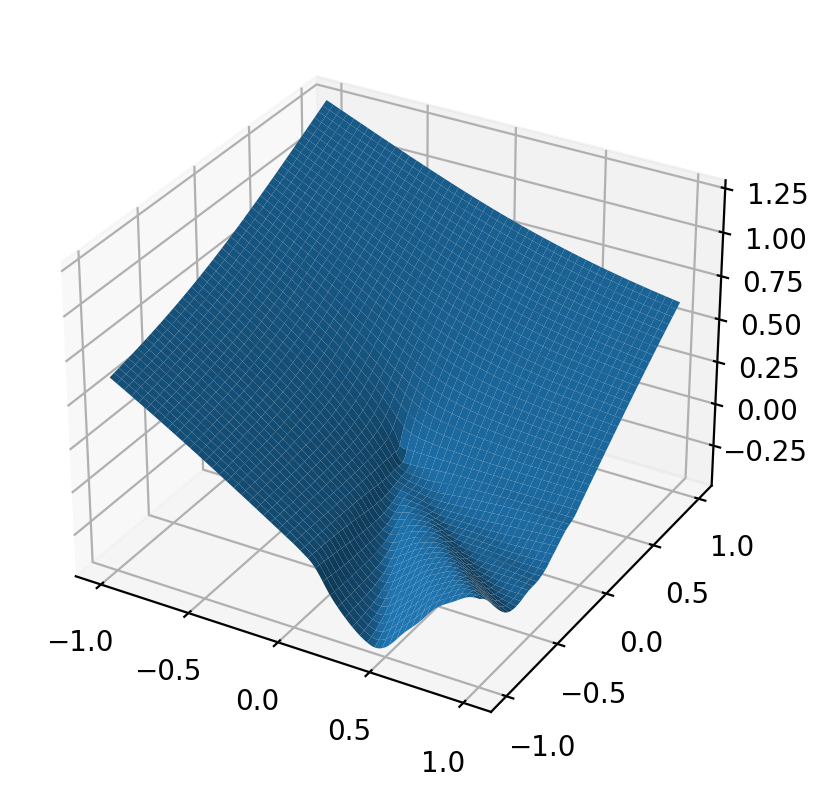

time taken:  35.02580714225769
neuron num 		 error 		 order
4 		 0.079597 		 * 		 

8 		 0.044613 		 0.835251 		 

16 		 0.013052 		 1.773160 		 

32 		 0.005583 		 1.225259 		 

64 		 0.002834 		 0.978017 		 

128 		 0.001244 		 1.187805 		 

256 		 0.000574 		 1.115751 		 

512 		 0.000221 		 1.378837 		 

1024 		 0.000100 		 1.139978 		 

neuron num  & 	 $\|u-u_n \|_{L^2}$ & 	 order \\ \hline \hline 
4 		 & 0.079597 &		 *  \\ \hline  

8 		 &  4.461e-02 &  		 0.84 \\ \hline  

16 		 &  1.305e-02 &  		 1.77 \\ \hline  

32 		 &  5.583e-03 &  		 1.23 \\ \hline  

64 		 &  2.834e-03 &  		 0.98 \\ \hline  

128 		 &  1.244e-03 &  		 1.19 \\ \hline  

256 		 &  5.741e-04 &  		 1.12 \\ \hline  

512 		 &  2.208e-04 &  		 1.38 \\ \hline  

1024 		 &  1.002e-04 &  		 1.14 \\ \hline  



In [6]:
def show_convergence_order(err_l2,exponent,dict_size, filename,write2file = False):
    
    if write2file:
        file_mode = "a" if os.path.exists(filename) else "w"
        f_write = open(filename, file_mode)
    
    neuron_nums = [2**j for j in range(2,exponent+1)]
    err_list = [err_l2[i] for i in neuron_nums ]

    # f_write.write('M:{}, relu {} \n'.format(M,k))
    if write2file:
        f_write.write('dictionary size: {}\n'.format(dict_size))
        f_write.write("neuron num \t\t error \t\t order \t\t h10 error \\ order \n")
    print("neuron num \t\t error \t\t order")
    for i, item in enumerate(err_list):
        if i == 0: 
            # print(neuron_nums[i], end = "\t\t")
            # print(item, end = "\t\t")
            
            # print("*")
            print("{} \t\t {:.6f} \t\t * \t\t \n".format(neuron_nums[i],item) )
            if write2file: 
                f_write.write("{} \t\t {} \t\t * \t\t \n".format(neuron_nums[i],item ))
        else:
            # print(neuron_nums[i], end = "\t\t")
            # print(item, end = "\t\t") 
            # print(np.log(err_list[i-1]/err_list[i])/np.log(2))
            print("{} \t\t {:.6f} \t\t {:.6f} \t\t \n".format(neuron_nums[i],item,np.log(err_list[i-1]/err_list[i])/np.log(2) ) )
            if write2file: 
                f_write.write("{} \t\t {} \t\t {}  \n".format(neuron_nums[i],item,np.log(err_list[i-1]/err_list[i])/np.log(2) ))
    if write2file:     
        f_write.write("\n")
        f_write.close()

def show_convergence_order_latex(err_l2,exponent): 
    neuron_nums = [2**j for j in range(2,exponent+1)]
    err_list = [err_l2[i] for i in neuron_nums ]
    print("neuron num  & \t $\|u-u_n \|_{L^2}$ & \t order \\\ \hline \hline ")
    for i, item in enumerate(err_list):
        if i == 0: 
            print("{} \t\t & {:.6f} &\t\t *  \\\ \hline  \n".format(neuron_nums[i],item, np.log(err_list[i-1]/err_list[i])/np.log(2) ) )   
        else: 
            print("{} \t\t &  {:.3e} &  \t\t {:.2f} \\\ \hline  \n".format(neuron_nums[i],item, np.log(err_list[i-1]/err_list[i])/np.log(2) ) )


def target(x):
    # Polar angle theta ∈ (-pi, pi]
    theta = torch.atan2(x[:,1], x[:,0])  # shape [N]
    
    # Shift to [0, 2pi)
    theta = torch.where(theta < 0, theta + 2 * pi, theta)

    # Radius r
    r = torch.sqrt(x[:,0]**2 + x[:,1]**2)

    # u = r^{2/3} * sin(2/3 * theta)
    u = r**(2/3) * torch.sin((2/3) * theta)

    return u.unsqueeze(1)  # make shape [N, 1] for consistency


# function_name = "gabor2d" 
function_name = "Lshape2d" 
filename_write = "data/2DQMCOGA-{}-order.txt".format(function_name)
f_write = open(filename_write, "a")
f_write.write("\n")
f_write.close() 

for N0 in [2**10]: 
    save = False
    f_write = open(filename_write, "a")
    my_model = None 
    s = 2**0
    Nx = 30 
    order = 3    
    exponent = 10
    num_epochs = 2**exponent  
    plot_freq = num_epochs
    relu_k = 2 
    Domain = [[-1,-1],[1,1]] 
    err_QMC2, my_model = OGAL2FittingReLU2D_QMC_Lshape(my_model,target,s,N0,num_epochs,plot_freq, Nx, order, k =relu_k, linear_solver = "direct",Domain = Domain)
    
    if save: 
        folder = 'data/'
        filename = folder + 'err_OGA_2D_{}_neuron_{}_N_{}_randomized.pt'.format(function_name,num_epochs,s*N0)
        torch.save(err_QMC2,filename) 
        folder = 'data/'
        filename = folder + 'model_OGA_2D_{}_neuron_{}_N_{}_randomized.pt'.format(function_name,num_epochs,s*N0)
        torch.save(my_model,filename)

    # neuron_nums = [2**j for j in range(2,exponent+1)]
    # err_list = [err_QMC2[i] for i in neuron_nums ]
    dict_size = s*N0 
    show_convergence_order(err_QMC2,exponent,dict_size, filename_write,write2file = True)
    show_convergence_order_latex(err_QMC2,exponent) 
    # f_write.write('dictionary size: {}\n'.format(s*N0))
    # f_write.write("neuron num \t\t error \t\t order\n")
    # print("neuron num \t\t error \t\t order")
    # for i, item in enumerate(err_list):
    #     if i == 0: 
    #         print(neuron_nums[i], end = "\t\t")
    #         print(item, end = "\t\t")
    #         print("*")
    #         f_write.write("{} \t\t {} \t\t * \n".format(neuron_nums[i],item))
    #     else: 
    #         print(neuron_nums[i], end = "\t\t")
    #         print(item, end = "\t\t") 
    #         print(np.log(err_list[i-1]/err_list[i])/np.log(2))
    #         f_write.write("{} \t\t {} \t\t {} \n".format(neuron_nums[i],item,np.log(err_list[i-1]/err_list[i])/np.log(2)))
    # f_write.write("\n")
    # f_write.close()


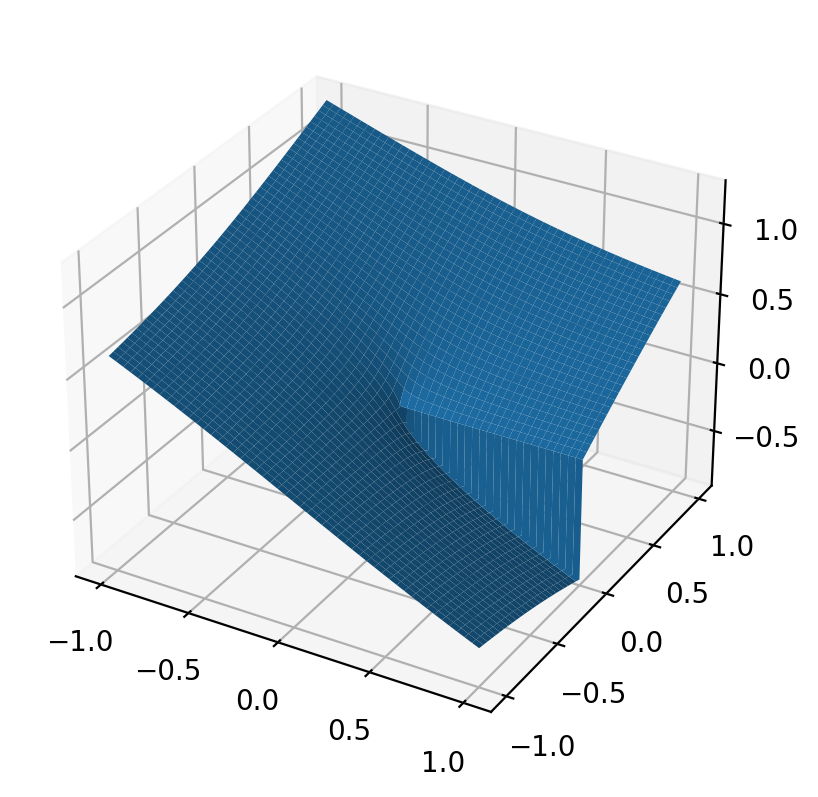

In [39]:
# def target(x):
#     """ Target function for the Poisson equation
#     """
    # return (x[:,0:1]**2 + x[:,1:2]**2)**0.5  

def target(x):
    # Polar angle theta ∈ (-pi, pi]
    theta = torch.atan2(x[:,1], x[:,0])  # shape [N]
    
    # Shift to [0, 2pi)
    theta = torch.where(theta < 0, theta + 2 * pi, theta)

    # Radius r
    r = torch.sqrt(x[:,0]**2 + x[:,1]**2)

    # u = r^{2/3} * sin(2/3 * theta)
    u = r**(2/3) * torch.sin((2/3) * theta)

    return u.unsqueeze(1)  # make shape [N, 1] 
plot_2D(target,bl = [-1,-1], ur=[1,1])

## color plot 

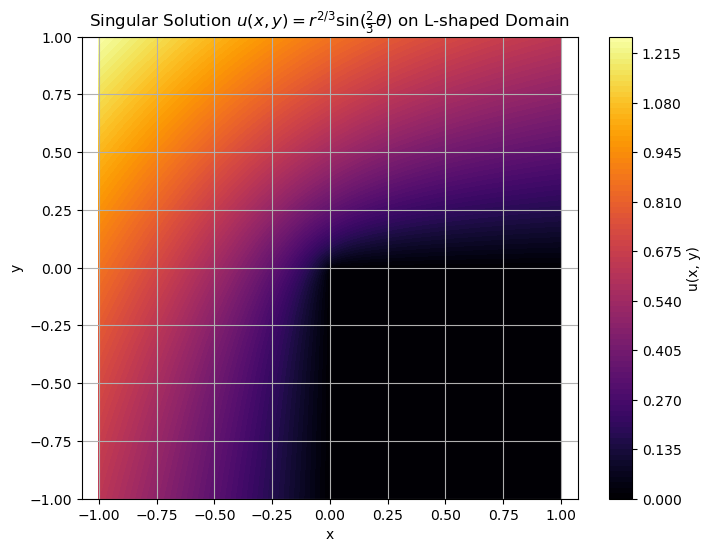

In [ ]:

# Re-implement target function using NumPy
def target_numpy(x, y):
    theta = np.arctan2(y, x)
    theta = np.where(theta < 0, theta + 2 * np.pi, theta)
    r = np.sqrt(x**2 + y**2)
    u = r**(2/3) * np.sin((2/3) * theta)
    return u

# Create grid
x_vals = np.linspace(-1, 1, 500)
y_vals = np.linspace(-1, 1, 500)
X, Y = np.meshgrid(x_vals, y_vals)

# Mask for L-shaped domain
mask = np.logical_or(X < 0, Y > 0)

# Compute the solution
U = np.zeros_like(X)
U[mask] = target_numpy(X[mask], Y[mask])

# Plot
plt.figure(figsize=(8, 6))
plt.contourf(X, Y, U, levels=100, cmap='inferno')
plt.colorbar(label='u(x, y)')
plt.title(r'Singular Solution $u(x, y) = r^{2/3} \sin(\frac{2}{3} \theta)$ on L-shaped Domain')
plt.xlabel('x')
plt.ylabel('y')
plt.axis('equal')
plt.grid(True)
plt.show()
